# Setup Libraries

Needed in google colab

In [1]:
pip install yfinance

     |████████████████████████████████| 63 kB 947 kB/s 
     |████████████████████████████████| 6.4 MB 19.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
#import matplotlib.mlab as mlab 
%matplotlib inline

# statistical calculation
#from scipy.stats import norm

import datetime as dt # For defining dates

import time

import yfinance as yf

# Get Stock Data

In [3]:
all_stocks = ["^GSPC", "^FTLC", "^RUT", "IEUS", "GOVT", "IGOV", "SIVR", "SGOL"]

In [4]:
def get_all_closes_of_stocks(tickers):
  i = 0
  stock_list = pd.DataFrame()
  for ticker in tickers:
    stock = yf.Ticker(ticker)        
    data = stock.history(start="2012-02-24",end ="2022-02-25")
    data.drop(data.columns[[0,1,2,4,5,6]], axis=1, inplace=True) # Just gets the adjacent close for each asset
    data.columns = [ticker]
    stock_list[ticker] = data.iloc[:,0]
  return stock_list.dropna()
stock_data = get_all_closes_of_stocks(all_stocks)
print(stock_data)

                  ^GSPC        ^FTLC         ^RUT       IEUS       GOVT  \
Date                                                                      
2012-02-24  1365.739990  3144.399902   826.919983  27.285177  21.551907   
2012-02-27  1367.589966  3133.399902   826.659973  27.201168  21.551907   
2012-02-28  1372.180054  3141.199951   823.799988  27.445547  21.551907   
2012-02-29  1365.680054  3112.399902   810.940002  27.155359  21.551907   
2012-03-01  1374.089966  3142.899902   815.219971  27.117172  21.551907   
...                 ...          ...          ...        ...        ...   
2022-02-17  4380.259766  4240.200195  2028.089966  63.590000  25.511517   
2022-02-18  4348.870117  4222.799805  2009.329956  62.840000  25.571404   
2022-02-22  4304.759766  4201.799805  1980.170044  61.560001  25.581383   
2022-02-23  4225.500000  4198.799805  1944.089966  60.889999  25.461611   
2022-02-24  4288.700195  4042.899902  1996.010010  60.000000  25.471592   

                 IGOV   

# Calculate Efiicient Frontier using pypfopt

In [5]:
pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 4.5 MB/s 
     |████████████████████████████████| 2.8 MB 17.3 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [6]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage


mu = mean_historical_return(stock_data)
S = CovarianceShrinkage(stock_data).ledoit_wolf()

from pypfopt.efficient_frontier import EfficientFrontier 

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe() # This gets rid of most of the assets

cleaned_weights = ef.clean_weights()
print(dict(cleaned_weights))
ef.portfolio_performance(verbose=True)

{'^GSPC': 0.51714, '^FTLC': 0.0, '^RUT': 0.0, 'IEUS': 0.0, 'GOVT': 0.48286, 'IGOV': 0.0, 'SIVR': 0.0, 'SGOL': 0.0}
Expected annual return: 7.5%
Annual volatility: 8.2%
Sharpe Ratio: 0.66


(0.07456821950972643, 0.08248375096660072, 0.6615632639187585)

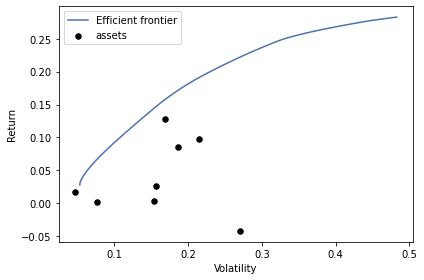

In [7]:
from pypfopt import plotting
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

## Format the Weights for Further Use

In [8]:
print(dict(cleaned_weights))

{'^GSPC': 0.51714, '^FTLC': 0.0, '^RUT': 0.0, 'IEUS': 0.0, 'GOVT': 0.48286, 'IGOV': 0.0, 'SIVR': 0.0, 'SGOL': 0.0}


In [9]:
tmp_list = []
for value, key in dict(cleaned_weights).items():
  tmp_list.append(key)

portfolio_weights = pd.Series(tmp_list, index=all_stocks)
portfolio_weights

^GSPC    0.51714
^FTLC    0.00000
^RUT     0.00000
IEUS     0.00000
GOVT     0.48286
IGOV     0.00000
SIVR     0.00000
SGOL     0.00000
dtype: float64

# Backtesting

## Test Year

In [10]:
initial_investment = 10000 # 10'000 dollar invesment. Can Change to 100'000 later 
trading_year = 252 # Number of trading days in a year
stock_returns = stock_data.pct_change() 

In [11]:
weighted_portfolio = portfolio_weights * initial_investment # Calculate the dollars invested in each asset in the portfolio
num_of_shares = weighted_portfolio / stock_data.iloc[(-trading_year),:] # Calculate the number of shares owned of each asset in the portfolio
portfolio_test_values = num_of_shares * stock_data.iloc[(-trading_year):,:] # share * share price = position value and it is done for each day in the trading year for all assets
portfolio_test_values['Total'] = portfolio_test_values.sum(axis=1)
portfolio_test_values

,^GSPC,^FTLC,^RUT,IEUS,GOVT,IGOV,SIVR,SGOL,Total
Date,,,,,,,,,
2021-02-04,5171.400000,0.0,0.0,0.0,4828.600000,0.0,0.0,0.0,10000.000000
2021-02-05,5191.555506,0.0,0.0,0.0,4821.438520,0.0,0.0,0.0,10012.994026
2021-02-08,5229.969634,0.0,0.0,0.0,4823.229149,0.0,0.0,0.0,10053.198783
2021-02-09,5224.145932,0.0,0.0,0.0,4826.809371,0.0,0.0,0.0,10050.955303
2021-02-10,5222.342636,0.0,0.0,0.0,4835.761480,0.0,0.0,0.0,10058.104116
...,...,...,...,...,...,...,...,...,...
2022-02-17,5850.618949,0.0,0.0,0.0,4620.943329,0.0,0.0,0.0,10471.562278
2022-02-18,5808.692469,0.0,0.0,0.0,4631.790748,0.0,0.0,0.0,10440.483217
2022-02-22,5749.775219,0.0,0.0,0.0,4633.598306,0.0,0.0,0.0,10383.373525


### Plot the portfolio

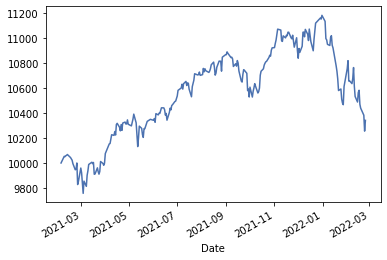

In [12]:
portfolio_test_values['Total'].plot() # Need to pretty this up for the dssertation or not use it at all

### Plot the Individual Assets

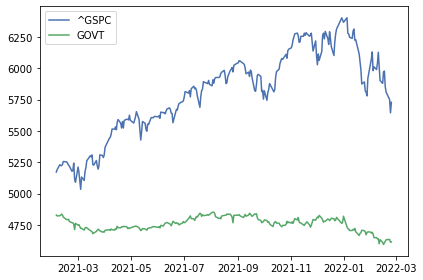

In [13]:
# Plotted on the same graph to see general trend
figure = plt.figure()
axis = plt.plot(portfolio_test_values.iloc[:,0:1], label='^GSPC')

axis = plt.plot(portfolio_test_values.iloc[:,4:5], label='GOVT')
plt.tight_layout()
plt.legend()
plt.show()

# Analyse the Test Year

## Sharpe Ratio

^GSPC    0.775173
GOVT    -0.831363
Total    0.449883
dtype: float64

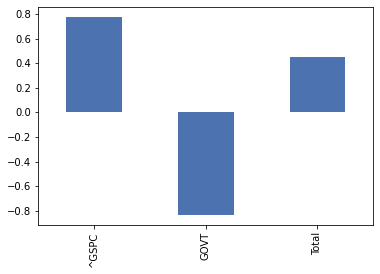

In [14]:
#daily_stock_returns = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
daily_stock_returns = portfolio_test_values.pct_change()
daily_stock_returns.drop(daily_stock_returns.columns[[1,2,3,5,6,7]], axis=1, inplace=True)
daily_stock_returns = daily_stock_returns.dropna()
#print(daily_stock_returns)
# To calculate sharpie ratio for individual stocks 
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 252 #252 trading days in a year
rf = 0 # I assume this to be 0 in my dissertation due to there not being a trully risk free asset
sharpes = daily_stock_returns.apply(sharpe_ratio, args=(N,rf,),axis=0)
sharpes.plot.bar()
sharpes

## Volatility

### Individual Stock Volatility

#### Rolling Volatilty for Each stock

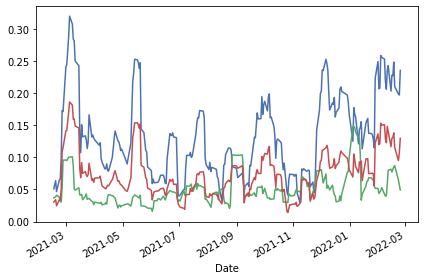

In [15]:
#data = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
rolling_stock = pd.DataFrame()
daily_stock_returns = portfolio_test_values.pct_change()
daily_stock_returns.drop(daily_stock_returns.columns[[1,2,3,5,6,7]], axis=1, inplace=True)
data = daily_stock_returns.dropna()
#print(data)
for stock in ["^GSPC","GOVT", "Total"]:
  rolling_stock[stock] = data[stock].rolling(7).std()*(252**0.5)
f1 = plt.figure()
for i in range(0,3):
  rolling_stock.iloc[:,i].plot()
  plt.tight_layout()
  #plt.show() # To display in separate graphs instead of 1

#### Anualised volatility for Each Stock

In [16]:
#data = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
stock_volatility = pd.DataFrame()
daily_stock_returns = portfolio_test_values.pct_change()
daily_stock_returns.drop(daily_stock_returns.columns[[1,2,3,5,6,7]], axis=1, inplace=True)
data = daily_stock_returns.dropna()
tmp = pd.DataFrame()
i = 0 
for stock in ["^GSPC","GOVT", "Total"]:
  tmp[stock] = data.iloc[:,i:(i+1)]
  stock_volatility = tmp.std()*(252**0.5)
  i = i + 1
print(stock_volatility)

^GSPC    0.146273
GOVT     0.053270
Total    0.082634
dtype: float64


### Portfolio Volatility

#### Just the Anualised Volatility for the Portfolio

In [17]:
total_portfolio_change = portfolio_test_values['Total'].pct_change().dropna()
portfolio_vol = total_portfolio_change.std()*(252**0.5)
portfolio_vol

0.08263421142922617

## Maximum Drawdown

^GSPC   -0.118501
GOVT    -0.053063
Total   -0.083094
dtype: float64

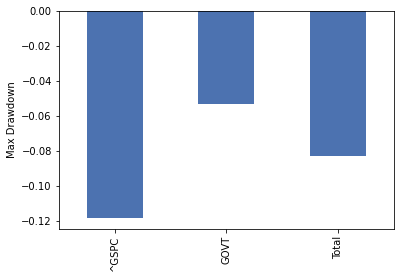

In [18]:
def max_drawdown(return_series):
    comp_ret = (return_series+1).cumprod()
    peak = comp_ret.expanding(min_periods=1).max()
    dd = (comp_ret/peak)-1
    return dd.min()

daily_stock_returns = portfolio_test_values.pct_change()
daily_stock_returns.drop(daily_stock_returns.columns[[1,2,3,5,6,7]], axis=1, inplace=True)
daily_stock_returns = daily_stock_returns.dropna()
max_drawdowns = daily_stock_returns.apply(max_drawdown,axis=0)
max_drawdowns.plot.bar()
plt.ylabel('Max Drawdown')
max_drawdowns

## Compound Annual Growth Rate (CARG)

In [19]:
start_value = portfolio_test_values.iloc[0,:]
end_value = portfolio_test_values.iloc[-1,:]
number_of_years =  round(len(portfolio_test_values)/252)
CARG = (((end_value / start_value) ** (1/number_of_years)) -1)# Shows % of values
CARG

^GSPC    0.107693
^FTLC         NaN
^RUT          NaN
IEUS          NaN
GOVT    -0.044503
IGOV          NaN
SIVR          NaN
SGOL          NaN
Total    0.034204
dtype: float64

## Calmar Ratio

^GSPC    0.968235
GOVT    -0.844546
Total    0.452719
dtype: float64

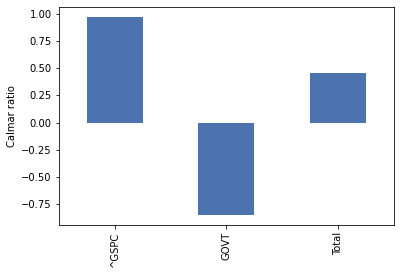

In [20]:
#daily_stock_returns = portfolio_position_values.pct_change().dropna() # Analysing holding such portfolio position from the start
daily_stock_returns = portfolio_test_values.pct_change()
daily_stock_returns.drop(daily_stock_returns.columns[[1,2,3,5,6,7]], axis=1, inplace=True)
daily_stock_returns = daily_stock_returns.dropna()
calmars = daily_stock_returns.mean()*255/abs(max_drawdowns)

calmars.plot.bar()
plt.ylabel('Calmar ratio')
calmars

## Value at Risk? Haven't decided if I want to include this or not

# Export Test Year to CSV

In [61]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [62]:
portfolio_test_values.to_csv('Mean-VarianceBenchmark.csv')

In [64]:
!cp Mean-VarianceBenchmark.csv "drive/My Drive/DisData"